In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
from gurobipy import *
import scipy

In [139]:
from math import *
def ent_rate_memory_exact(p_list,W):
#     p_list = [p]*N
    N = len(p_list) # number of links (or number of repeaters -1)
    Q = np.zeros((W,N)) 
    for k, p_k in enumerate(p_list):
        for i in range(W):
            Q[i,k] = comb(W,i+1)* p_k**(i+1) * (1-p_k)**(W-i-1)

    P = np.zeros((W,N)) 
    P[:,0] = Q[:,0]     
    for k in range(1,N):
        for i in range(W):
            P[i,k] = P[i,k-1]* np.sum(Q[i:,k]) + Q[i,k]* np.sum(P[i+1:,k-1])

    return np.sum(np.arange(1,W+1)*P[:,N-1])

def ent_rate_minimize(p,p0,N,W):
    p_list = [p]*N
#     N = len(p_list) # number of links (or number of repeaters -1)
    Q = np.zeros((W,N)) 
    for k, p_k in enumerate(p_list):
        for i in range(W):
            Q[i,k] = comb(W,i+1)* p_k**(i+1) * (1-p_k)**(W-i-1)

    P = np.zeros((W,N)) 
    P[:,0] = Q[:,0]     
    for k in range(1,N):
        for i in range(W):
            P[i,k] = P[i,k-1]* np.sum(Q[i:,k]) + Q[i,k]* np.sum(P[i+1:,k-1])

    return (np.sum(np.arange(1,W+1)*P[:,N-1])-p0)**2

# p = 0.2
# N = 100
# w = 100
# p0 = w*0.1
# # ent_rate_memory_exact(p,N,w)/w
# p_res = scipy.optimize.fmin(ent_rate_minimize, x0=0.5, args=(p0,N,w))

# print(p_res,ent_rate_memory_exact(p_res,N,w))

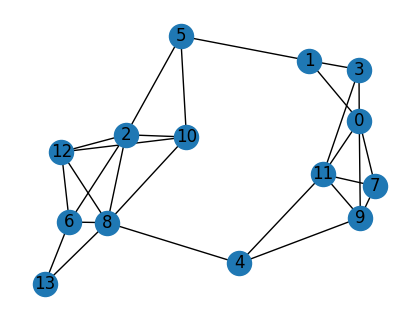

39.30263446402345


In [84]:
# random network graph
N = 14# number of nodes
node_list = np.arange(N)

L0 = 100
length = L0
width = L0
dmax = 0.4*L0
# np.random.seed = 3
random.seed(20)
pos = dict()
for node in range(N):
    pos[node] = (random.random()*length,random.random()*width)
    
G = nx.random_geometric_graph(N, dmax, dim=2, pos=pos, p=2)

weights = dict()
transmission = dict()
for e in G.edges():
    dist = np.linalg.norm([pos[e[0]][0]-pos[e[1]][0],pos[e[0]][1]-pos[e[1]][1]])
    weights[e] = dist
    transmission[e] = 10**(-0.2*dist/10)
    
nx.set_edge_attributes(G, values = weights, name = 'weight')
nx.set_edge_attributes(G, values = transmission, name = 'trans')

plt.figure(figsize=(4,3))
nx.draw(G,pos,with_labels=True)
plt.show()

print(nx.shortest_path_length(G, source=4, target=8, weight="weight"))

In [163]:
Nmax = 4
Rmin = 3
w_list = range(30,32)

######## max link distance
Lmax_w = np.zeros(len(w_list))
for i_w, memory in enumerate(w_list):
    p_res = scipy.optimize.fmin(ent_rate_minimize, x0=1.0, args=(Rmin,Nmax,memory),disp=False)
    Lmax_w[i_w] = -50*np.log10(p_res)
#     print(p_res,ent_rate_memory_exact([p_res]*Nmax,memory))
###########################
print(Lmax_w)

[38.83980981 39.52267853]


In [164]:
# Nmax = 10

# W = 3
# D0 = 5
# D = D0*np.ones(N)
# s_list = [9,3]# source
# t_list = [10,13] # destination
s_list = [13,12,10] # source
t_list = [9,11,7] # destination
C = len(s_list)

# indices: (superscript, subscript)
m = Model()
x = m.addMVar((C,len(w_list),N,N), vtype=GRB.BINARY,name="x")
# yu = m.addMVar((N), vtype=GRB.BINARY,name="yu")
yu = m.addMVar((N), vtype=GRB.INTEGER,name="yu")

R_list = list(set(node_list)-set(np.concatenate((s_list,t_list))))

for user_pair in range(C):
    s = s_list[user_pair]
    t = t_list[user_pair]
    for memory in range(len(w_list)):
        
        number = 0
        for n1 in R_list:
#             m.addConstr( nx.shortest_path_length(G, source=s, target=n1, weight="weight")*x[user_pair][memory][s][n1] <= Lmax ) 
#             m.addConstr( nx.shortest_path_length(G, source=n1, target=t, weight="weight")*x[user_pair][memory][n1][t] <= Lmax ) 
            
            if nx.has_path(G, source=s, target=n1):
                l_uv = nx.shortest_path_length(G, source=s, target=n1, weight="weight")
                m.addConstr( l_uv*x[user_pair][memory][s][n1] <= Lmax_w[memory] ) 
#                 path_length += l_uv*x[user_pair][memory][s][n1]
            else:
                m.addConstr( x[user_pair][memory][s][n1] == 0 ) 

            if nx.has_path(G, source=n1, target=t):
                l_uv = nx.shortest_path_length(G, source=n1, target=t, weight="weight")
                m.addConstr( l_uv*x[user_pair][memory][n1][t] <= Lmax_w[memory] ) 
#                 path_length += l_uv*x[user_pair][memory][n1][t]
            else:
                m.addConstr( x[user_pair][memory][n1][t] == 0 ) 

            path = x[user_pair][memory][n1][t] - x[user_pair][memory][s][n1]
            number += x[user_pair][memory][s][n1]+ x[user_pair][memory][n1][t]
            for n2 in R_list:
                if n2 != n1:
#                     m.addConstr( nx.shortest_path_length(G, source=n1, target=n2, weight="weight")*x[user_pair][memory][n1][n2] <= Lmax ) 
                    if nx.has_path(G, source=n1, target=n2):
                        l_uv = nx.shortest_path_length(G, source=n1, target=n2, weight="weight")
                        m.addConstr( l_uv*x[user_pair][memory][n1][n2] <= Lmax_w[memory] ) 
#                         path_length += l_uv*x[user_pair][memory][n1][n2]
                    else:
                        m.addConstr( x[user_pair][memory][n1][n2] == 0 ) 

                    path += x[user_pair][memory][n1][n2] - x[user_pair][memory][n2][n1]
                    number += x[user_pair][memory][n1][n2]

            m.addConstr( path == 0 ) 
        m.addConstr( number <= Nmax + 1 ) 
        m.addConstr( nx.shortest_path_length(G, source=s, target=t, weight="weight")*x[user_pair][memory][s][t] <= Lmax_w[memory] ) 

wx_sum = 0 
for user_pair in range(C):
    s = s_list[user_pair]
    t = t_list[user_pair]
    path_s = 0
    path_t = 0
    for memory in range(len(w_list)):        
        wx_sum += w_list[memory]*x[user_pair][memory][s][t]
        path_s += x[user_pair][memory][s][t]
        path_t += x[user_pair][memory][s][t]
        for n1 in R_list:
            wx_sum += w_list[memory]*x[user_pair][memory][s][n1]
            path_s += x[user_pair][memory][s][n1]
            path_t += x[user_pair][memory][n1][t]

    m.addConstr( path_s == 1 )
    m.addConstr( path_t == 1 )
   
for n1 in R_list:
    y1_const = 0
    y2_const = 0
    for user_pair in range(C):
        s = s_list[user_pair]
        t = t_list[user_pair]
        for memory in range(len(w_list)):        
            y1_const += w_list[memory]*x[user_pair][memory][n1][t]
            y2_const += w_list[memory]*x[user_pair][memory][s][n1]
            for n2 in R_list:
                if n2 != n1:
                    y1_const += w_list[memory]*x[user_pair][memory][n1][n2]
                    y2_const += w_list[memory]*x[user_pair][memory][n2][n1]
#     m.addConstr( y1_const <= D[n1]*yu[n1] ) 
#     m.addConstr( y2_const <= D[n1]*yu[n1] ) 
    m.addConstr( y1_const <= yu[n1] ) 
    m.addConstr( y2_const <= yu[n1] ) 


for n1 in range(N):
    for n2 in range(N):
        if n2 != n1:
            for user_pair in range(C):
                x_const = 0
                for memory in range(len(w_list)):
                    x_const += x[user_pair][memory][n1][n2]

                m.addConstr( x_const <= 1 ) 

y_sum = 0
for n1 in range(N):
    if (n1 not in s_list) and (n1 not in t_list):
        y_sum += yu[n1]

m.setObjective(y_sum , GRB.MINIMIZE)
m.optimize()

x_opt = np.zeros((C,len(w_list),N,N))
y_opt = np.zeros(N)
for i in range(N):
    if m.getVars()[len(s_list)*len(w_list)*N**2+i].X > 0:
        y_opt[i] = m.getVars()[len(s_list)*len(w_list)*N**2+i].X
    for j in range(N):
        for user_pair in range(C):
            for memory in range(len(w_list)):
                if m.getVars()[(user_pair*len(w_list)+memory)*N**2+i*N+j].X > 0:
                    x_opt[user_pair,memory,i,j] = m.getVars()[(user_pair*len(w_list)+memory)*N**2+i*N+j].X
                    
                    

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1060 rows, 1190 columns and 3622 nonzeros
Model fingerprint: 0x72ee3052
Variable types: 0 continuous, 1190 integer (1176 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]
Presolve removed 981 rows and 1106 columns
Presolve time: 0.00s
Presolved: 79 rows, 84 columns, 442 nonzeros
Variable types: 0 continuous, 84 integer (77 binary)
Found heuristic solution: objective 310.0000000
Found heuristic solution: objective 306.0000000

Root relaxation: objective 2.760000e+02, 17 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Tim

(13, 9) : []
(13, 9) : [array([4, 9]), array([8, 4]), array([13,  8])]
(12, 11) : []
(12, 11) : [array([1, 3]), array([2, 5]), array([ 3, 11]), array([5, 1]), array([12,  2])]
(10, 7) : [array([0, 7]), array([1, 0]), array([5, 1]), array([10,  5])]
(10, 7) : []


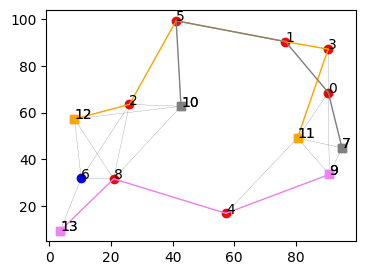

[30. 61. 31. 31. 31. 61.  0.  0. 31.  0.  0.  0.  0.  0.]


In [165]:
# Gopt = G.copy()
# Gopt = nx.Graph()
# Gopt.add_nodes_from(np.arange(N))
# Gopt= nx.from_numpy_array(x_opt)
plt.figure(figsize=(4,3))
# nx.draw(Gopt, pos, with_labels=True)
for i,y in enumerate(y_opt):
    if i not in np.concatenate((s_list,t_list)):
        if y > 0:
            plt.plot(pos[i][0],pos[i][1],"ro")#,markersize=5)
            plt.text(pos[i][0],pos[i][1],"%d" % i)
        else:
            plt.plot(pos[i][0],pos[i][1],"bo")
            plt.text(pos[i][0],pos[i][1],"%d" % i)
            
for e in G.edges():
    plt.plot([ pos[e[0]][0],pos[e[1]][0] ], [ pos[e[0]][1],pos[e[1]][1] ], color = "black", linewidth=0.1)
            
colors = ["violet","orange","gray"]
for user_pair in range(C):
    for memory in range(len(w_list)):
        s = s_list[user_pair]
        plt.plot(pos[s][0],pos[s][1],"s", color = colors[user_pair])
        plt.text(pos[s][0],pos[s][1],"%d" % s)
        t = t_list[user_pair]
        plt.plot(pos[t][0],pos[t][1],"s", color = colors[user_pair])
        plt.text(pos[t][0],pos[t][1],"%d" % t)

        edges = np.argwhere(x_opt[user_pair,memory,:,:]>0)
        path_output = []
        for e in edges:
            if G.has_edge(e[0],e[1]):
                plt.plot([ pos[e[0]][0],pos[e[1]][0] ], [ pos[e[0]][1],pos[e[1]][1] ], color = colors[user_pair], linewidth=1)
                path_output.append(e)
            else:
                path = nx.shortest_path(G, source=e[0], target=e[1], weight="weight")
                path_output.append(path)
                for i in range(len(path)-1):
                    e1 = path[i]
                    e2 = path[i+1]
                    plt.plot([ pos[e1][0],pos[e2][0] ], [ pos[e1][1],pos[e2][1] ], color = colors[user_pair], linewidth=1)

        print((s_list[user_pair],t_list[user_pair]),":",path_output)
plt.show()
print(y_opt)


In [166]:
for user_pair in range(C):
    s = s_list[user_pair]
    for memory in range(len(w_list)):
        if np.sum(x_opt[user_pair][memory][s][:])>0:
            w_ind = memory
            w_res = w_list[memory]
#     print((s_list[user_pair],t_list[user_pair]),":",w_res,w_ind)
            
    # print(np.sum(x_opt[user_pair][:][s][:],axis=0))
    edges = np.argwhere(x_opt[user_pair,w_ind,:,:]>0)
    path_prob = []
    path_dist = []
    for e in edges:
        path_prob.append(10**(-0.2*nx.shortest_path_length(G, source=e[0], target=e[1], weight="weight")/10) )
        path_dist.append( nx.shortest_path_length(G, source=e[0], target=e[1], weight="weight") )
#     print(edges)
    print(path_prob)
    print((s_list[user_pair],t_list[user_pair]),":", Rmin, ent_rate_memory_exact(path_prob,w_res))



[0.1781717514441682, 0.16366179523530663, 0.2727866108366881]
(13, 9) : 3 4.032718279365749
[0.5195245278892203, 0.16678901971461324, 0.1638387657326361, 0.18533016535322505, 0.4187932951455541]
(12, 11) : 3 3.579399256268686
[0.3296417008360259, 0.30350170617914385, 0.18533016535322505, 0.1849294032550947]
(10, 7) : 3 4.269188612961557
